In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils_unet import * 
from utils_models import * 
from utils_data import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import pickle

from sklearn.metrics import r2_score, mean_squared_error, f1_score,confusion_matrix
from sklearn.neural_network import MLPRegressor, MLPClassifier

/home-nfs/tenzorok/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/home-nfs/tenzorok/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
plt.rcParams.update({'font.size': 18})

In this notebook, we'd like to show the main idea how to train and use the stacking model. It's the same idea for regression and tercile classification (for classification, we work with probabilities). 

So, here we assume a RF model as an exmaple:
* train RF model on a half of the train data (a), get predictions on another half (b)
* use (b) predictions to train a stacking model 
* train RF model using full train data (a + b), get its predictions on test/validation
* apply trained stacking model to the predictions of models on validation or test

You can use a similar scheme to other models for stacking (U-Net and LR). 

## Getting data train-validation

In [5]:
# define target to be from 'precip_ncep' 'tmp_ncep' 'precip_nasa' 'tmp_nasa'
TARGET = 'precip_ncep'

PATH = '/share/data/willett-group/climate/'

In [6]:
ens_forecasts_all, target_rect, target_for_lags = get_train_val_ens_target(TARGET, PATH)

tmp_precip, rhum, ght, pressure, sst_train, sst_val = get_train_val_obs_data(TARGET, PATH)
    

mask_US = np.load('data/US_rect_mask_Larger_fixed.npy')

print(ens_forecasts_all.shape, target_rect.shape, mask_US.shape)

(312, 24, 64, 128) (312, 64, 128) (64, 128)


In [7]:
tmp_precip.shape, ght.shape, pressure.shape

((324, 64, 128), (324, 64, 128), (324, 64, 128))

In [8]:
sst_train.shape, sst_val.shape

((249, 100), (63, 100))

In [9]:
mask_US_cropped = crop_to_US_land(mask_US)

In [10]:
# let's define positional encoding

grid_lat, grid_lon = np.mgrid[52.75:21.25:64j, 233.25:296.75:128j]

coordinates = np.zeros((2, grid_lat.shape[0], grid_lat.shape[1]))
coordinates[0] = grid_lat
coordinates[1] = grid_lon

PE_dim = 12
pe0 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[0].reshape(64*128))
pe1 = sinusoid_positional_encoding_ref(64*128, PE_dim, coordinates[1].reshape(64*128))

pe_channels = np.zeros((PE_dim*2, 64, 128))
pe_channels[:PE_dim, :, :] = pe0.T.reshape(PE_dim, 64, 128)
pe_channels[-PE_dim:, :, :] = pe1.T.reshape(PE_dim, 64, 128)

In [11]:
train_val_size = 312

sst_ftr = np.concatenate((sst_train[:, :8], sst_val[:, :8]), axis=0)
sst_img = np.zeros((train_val_size, 8, 64, 128))

for i in range(train_val_size):
    for j in range(8): # number of components
        sst_img[i, j, :, :] = np.full((64, 128), sst_ftr[i, j])

In [13]:
# create features 
# it's easy to vary what features to include
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    dim_shape = 24 + 24 + 5 + 4 + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :24, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 24, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 25, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 26, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 27, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 28, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 29, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 30, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 31, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 32, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 33:33+2*PE_dim, :, :] = pe_channels
    X_ftrs_hind[:, -8:, :, :] = sst_img
    
elif TARGET == 'tmp_nasa' or TARGET == 'precip_nasa':
    print(TARGET)
    dim_shape = 11 + 4 + 24 + 5# + 8
    X_ftrs_hind = np.zeros((312, dim_shape, ens_forecasts_all.shape[2], ens_forecasts_all.shape[3]))
    X_ftrs_hind[:, :11, :, :] = ens_forecasts_all

    for i in range(len(X_ftrs_hind)):
        X_ftrs_hind[i, 11, :, :] = target_for_lags[i+24-2, :, :]
        X_ftrs_hind[i, 12, :, :] = target_for_lags[i+24-3, :, :]
        X_ftrs_hind[i, 13, :, :] = target_for_lags[i+24-4, :, :]
        X_ftrs_hind[i, 14, :, :] = target_for_lags[i+24-12, :, :]
        X_ftrs_hind[i, 15, :, :] = target_for_lags[i+24-24, :, :]

        X_ftrs_hind[i, 16, :, :] = tmp_precip[i+12-2, :, :]
        X_ftrs_hind[i, 17, :, :] = ght[i+12-2, :, :]
        X_ftrs_hind[i, 18, :, :] = pressure[i+12-2, :, :]
        X_ftrs_hind[i, 19, :, :] = rhum[i+12-2, :, :]

    X_ftrs_hind[:, 20:20+2*PE_dim, :, :] = pe_channels
#     X_ftrs_hind[:, -8:, :, :] = sst_img

In [14]:
trend = get_obs_trend(TARGET, PATH)
trend[:, mask_US == 0] = 0

precip


In [15]:
trend_cropped_US = np.zeros((trend.shape[0], 48, 115))

for i in range(trend.shape[0]):
    trend_cropped_US[i] = crop_to_US_land(trend[i])

In [16]:
train_size = 249 // 2
stacking_size = 249 // 2 + 1
test_size = 249

Here, we train RF on the first half of the train data.

In [17]:
if TARGET == 'tmp_ncep' or TARGET == 'precip_ncep':
    print('ncep')
    rf_object = generate_RF_predictions(X_ftrs_hind, target_rect, mask_US,
                                        drop_positional_encodings=False,
                                        train_size=train_size, 
                                        positional_encoding_channels=range(33, 33+2*PE_dim))
else:
    print('nasa')
    rf_object = generate_RF_predictions(X_ftrs_hind, target_rect, mask_US,
                                        drop_positional_encodings=False, 
                                        train_size=train_size, 
                                    positional_encoding_channels=range(20, 20+2*PE_dim))

ncep


In [18]:
rf_object.train_model()

rf_preds_for_stack = rf_object.return_predictions(include='all', output_format='grid', 
                                         output_original_grid=True)

Getting predictions of models trained on the first half of the train data.

In [19]:
if TARGET == 'precip_ncep':
    print('getting precip ncep')
    unet_for_stack = np.load('data/unet_outputs_precip_ncep+stack.npy')
    lr_for_stack  = np.load('data/LinR_precip_ncep_best_stack.npy') # np.load('data/LogR_probs_precip_NCEP_stack.npy')
elif TARGET == 'tmp_ncep':
    print('getting tmp ncep')
    unet_for_stack = np.load('data/unet_outputs_tmp_nasa_woSST_stack.npy') # unet_outputs_tmp_ncep_stack
    lr_for_stack  = np.load('data/LinR_tmp_ncep_wosst_stack.npy') # LinR_tmp_ncep_best_stack
elif TARGET == 'precip_nasa':
    unet_for_stack = np.load('data/unet_outputs_precip_nasa_stack.npy')
    lr_for_stack  = np.load('data/LinR_precip_nasa_best_stack.npy')
elif TARGET == 'tmp_nasa':
    # unet_outputs_tmp_nasa_woSST_stack
    unet_for_stack = np.load('data/unet_outputs_tmp_nasa_stack.npy') #unet_outputs_tmp_nasa_stack
    # LinR_tmp_nasa_wosst_stack
    lr_for_stack  = np.load('data/LinR_tmp_nasa_best_stack.npy') # LinR_tmp_nasa_best_stack

getting precip ncep


In [20]:
NUM_LOC = 3274
NUMFTRS = 3
X_ftrs = np.zeros((312, NUM_LOC, NUMFTRS))
X_ftrs[:, :, 0] = rf_preds_for_stack[:, mask_US==1]
X_ftrs[:, :, 1] = unet_for_stack[:, mask_US_cropped==1]
X_ftrs[:, :, 2] = lr_for_stack[:, mask_US==1]

In [21]:
X_train = X_ftrs[train_size:test_size]
X_test = X_ftrs[249:]
y_train = np.array(target_rect[train_size:test_size, mask_US==1])
y_test = np.array(target_rect[test_size:, mask_US==1])

X_mins = np.min(X_train, axis=(0, 1)).reshape(1, 1, X_ftrs.shape[2]) #np.amin(X_train)
X_maxs = np.max(X_train, axis=(0, 1)).reshape(1, 1, X_ftrs.shape[2]) #np.amax(X_train)
X_train = X_train - X_mins
X_test = X_test - X_mins
X_train = X_train/(X_maxs - X_mins)
X_test = X_test/(X_maxs - X_mins)

y_min = np.min(y_train)
y_max = np.max(y_train)
y_train = y_train - y_min
y_test = y_test - y_min
y_train = y_train/(y_max - y_min)
y_test = y_test/(y_max - y_min)
# y_mean = np.mean(y_train)
# y_std = np.std(y_train)
# y_train = (y_train - y_mean) / y_std
# y_test = (y_test - y_mean) / y_std

print(np.min(X_train), np.max(X_train), np.min(X_test), np.max(X_test))
print(np.min(y_train), np.max(y_train), np.min(y_test), np.max(y_test))

0.0 1.0 0.00021037723838679615 0.9691178390733254
0.0 1.0 0.0 1.005818978916764


In [22]:
X_train = X_train.reshape(-1, NUMFTRS)
X_test = X_test.reshape(-1, NUMFTRS)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

Train the stacking model

In [23]:
regr = MLPRegressor(random_state=42, solver='lbfgs', max_iter=15, alpha=0.01, 
                    activation='logistic', hidden_layer_sizes=(100)).fit(X_train, y_train)

pred_test = regr.predict(X_test)

In [24]:
pred_test = pred_test.squeeze() * (y_max - y_min) + y_min

pred_train = regr.predict(X_train)
pred_train = pred_train.squeeze() * (y_max - y_min) + y_min

### Go to fully trained models RF/UNET

After we trained the stacking model, we can use our models that were trained on all train data. here we go to the test set (all models were trained using 249 time steps, and there are their predictions on test)

In [25]:
if TARGET == 'precip_ncep': 
    unet_preds = np.load('data/unet_2011_20_ncep_precip.npy') 
    rf_preds = np.load('data/rf_preds_ncep_realprecip_2020.npy') 
    lr_preds = np.load('data/test_2011_2018/LR_precip_ncep_all_ftrs_2020.npy')
#     lr_preds = np.load('data/test_2011_2018/LR_ens_only_precip_ncep_new.npy') 
    NUM_STEPS = 93 + 24
    
    test_target = np.load(PATH + 'data/test_2020/precip_test_2011_2020.npy')
    test_target = test_target[3:] * mask_US
    
elif TARGET == 'precip_nasa': 
    unet_preds = np.load('data/unet_2011_18_gmao_precip.npy') 
    rf_preds = np.load('data/test_2011_2018/RF_precip_nasa_new.npy') 
    lr_preds = np.load('data/test_2011_2018/LR_precip_nasa_new.npy')
#     lr_preds = np.load('data/test_2011_2018/LR_ens_only_precip_nasa_new.npy')
    NUM_STEPS = 85
    
    test_target = np.load(PATH + 'data/precip_US_rect_Larger_2011_2018.npy')
    test_target = test_target[:-11] * mask_US
    
elif TARGET == 'tmp_ncep': 
    unet_preds = np.load('data/unet_2011_20_ncep_tmp_new.npy') #np.load('data/unet_2011_20_ncep_tmp.npy') 
    rf_preds = np.load('data/rf_preds_ncep_precip_2020.npy') 
    #np.load('data/test_2011_2018/RF_tmp_ncep_new.npy') 
    #lr_preds = np.load('data/test_2011_2018/LR_tmp_ncep_new.npy')
    lr_preds = lr_preds = np.load('data/test_2011_2018/LR_tmp_ncep_all_2020.npy')#np.load('data/test_2011_2018/LR_ens_only_tmp_ncep_new.npy')
    NUM_STEPS = 93 + 24
    
    test_target = np.load(PATH + 'data/test_2020/tmp_test_2011_2020.npy')
    test_target = test_target[3:] * mask_US
    
elif TARGET == 'tmp_nasa': 
    unet_preds = np.load('data/unet_2011_18_gmao_tmp.npy') 
    rf_preds = np.load('data/test_2011_2018/RF_tmp_nasa_new.npy') 
#     lr_preds = np.load('data/test_2011_2018/LR_tmp_nasa_new.npy')
    lr_preds = np.load('data/test_2011_2018/LR_ens_only_tmp_nasa_new.npy')
    NUM_STEPS = 85
    
    test_target = np.load(PATH + 'data/tmp_US_rect_Larger_2011_2018.npy')
    test_target = test_target[:-11] * mask_US
    
else:
    print('NO DATA')
    
print(unet_preds.shape, rf_preds.shape, lr_preds.shape, test_target.shape)

(117, 64, 128) (117, 48, 115) (117, 64, 128) (117, 64, 128)


In [26]:
test_target_cropped = np.zeros((test_target.shape[0], 48, 115))

for i in range(test_target.shape[0]):
    test_target_cropped[i] = crop_to_US_land(test_target[i])

In [27]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    target_test_detrended = test_target_cropped - trend_cropped_US[3:3+93+24]
else:
    target_test_detrended = test_target_cropped[train_size:] - trend_cropped_US[:85]

In [28]:
NUM_LOC = 3274
NUMFTRS = 3

X_ftrs = np.zeros((NUM_STEPS, NUM_LOC, NUMFTRS))
X_ftrs[:, :, 0] = rf_preds[:,  mask_US_cropped==1]
X_ftrs[:, :, 1] = unet_preds[:, mask_US==1]
X_ftrs[:, :, 2] = lr_preds[:,  mask_US==1]

In [29]:
X_ftrs = (X_ftrs - X_mins) / (X_maxs - X_mins)

In [30]:
X_ftrs = X_ftrs.reshape(-1, NUMFTRS)

In [31]:
pred_stacking = regr.predict(X_ftrs)

In [32]:
pred_stacking = pred_stacking * (y_max - y_min) + y_min

In [33]:
pred_stacking = pred_stacking.reshape(NUM_STEPS, 3274)

In [34]:
pred_stacking_img = np.zeros((NUM_STEPS, 48, 115))

for i in range(NUM_STEPS):
    pred_stacking_img[i] = convert_1d_to_2d(pred_stacking[i], mask_US_cropped)[0]

In [35]:
if 'ncep' in TARGET:
    # shift trend for NCEP data
    preds_test_detrended = pred_stacking_img - trend_cropped_US[3:3+93+24]
else: 
    preds_test_detrended = pred_stacking_img - trend_cropped_US[:85]

In [36]:
model_performance(test_target[:, mask_US==1], pred_stacking)

array([2.07, 1.99, 0.03, 1.42, 2.96, 4.38])

In [37]:
target_test_detrended.shape

(117, 48, 115)

In [38]:
r2_test = avg_r2(target_test_detrended, preds_test_detrended, mask_US_cropped)

Avg r2 : 0.02 
Median r2: 0.04  


<ipython-input-74-55db1136a8d0>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  r2_test[mask_US_cropped == 0] = np.float('NaN')


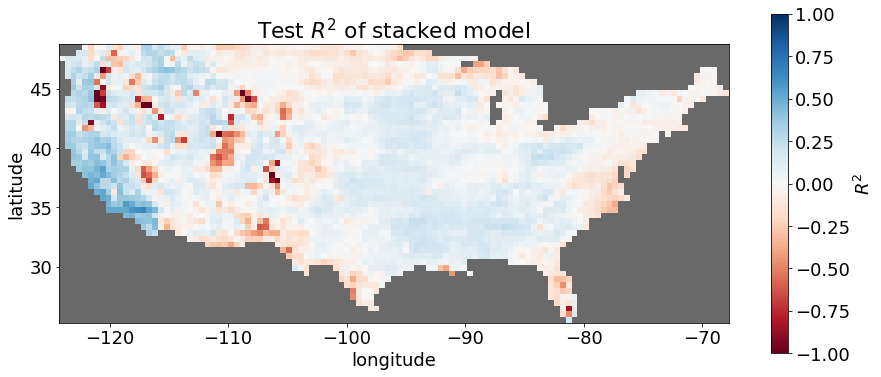

In [74]:
r2_test[mask_US_cropped == 0] = np.float('NaN')
cmap = plt.cm.RdBu
cmap.set_bad('dimgrey',1.)
plt.imshow(r2_test, extent=(-124.25,-67.75,25.25,48.75), cmap=cmap)
plt.title('Test $R^2$ of stacked model')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.clim(-1,1)
cbar = plt.colorbar(shrink=0.5)
plt.gcf().set_size_inches(15,12.5)
cbar.set_label('$R^2$')